In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import math
from statsmodels.stats import diagnostic
import statsmodels.stats as st
from scipy import stats
import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
# from sklearn.preprocessing import OneHotEncoder
# from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve

from director_scrap import director_scrap

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

# 1. Wikipedia movie ID
# 2. Freebase movie ID
# 3. Movie release date
# 4. Character name
# 5. Actor date of birth
# 6. Actor gender
# 7. Actor height (in meters)
# 8. Actor ethnicity (Freebase ID)
# 9. Actor name
# 10. Actor age at movie release
# 11. Freebase character/actor map ID
# 12. Freebase character ID
# 13. Freebase actor ID

columns_char = ['Wiki_ID', 'Freebase_ID', 'Movie_release', 'Char_name', 'Actor_birth', 'Actor_gender', 
               'Actor_height', 'Actor_ethnicity', 'Actor_name', 'Actor_age_release', 'Char/Actor_map', 
               'Char_ID', 'Actor_ID']
df_char = pd.read_table('data/character.metadata.tsv', header=None, names=columns_char)
df_char.head(2)

,Wiki_ID,Freebase_ID,Movie_release,Char_name,Actor_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release,Char/Actor_map,Char_ID,Actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


In [4]:
# Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

# 1. Wikipedia movie ID
# 2. Freebase movie ID
# 3. Movie name
# 4. Movie release date
# 5. Movie box office revenue
# 6. Movie runtime
# 7. Movie languages (Freebase ID:name tuples)
# 8. Movie countries (Freebase ID:name tuples)
# 9. Movie genres (Freebase ID:name tuples)

columns_mov = ['Wiki_ID', 'Freebase_ID', 'Movie_name', 'Movie_release', 'Movie_revenue', 'Movie_runtime', 
               'Movie_languages', 'Movie_countries', 'Movie_genres']
df_mov = pd.read_table('data/movie.metadata.tsv', header=None, names=columns_mov)
df_mov.head(2)

,Wiki_ID,Freebase_ID,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


In [5]:
print(f"Movie : {len(df_mov)}      Actor : {len(df_char)}")

Movie : 81741      Actor : 450669


<Axes: >

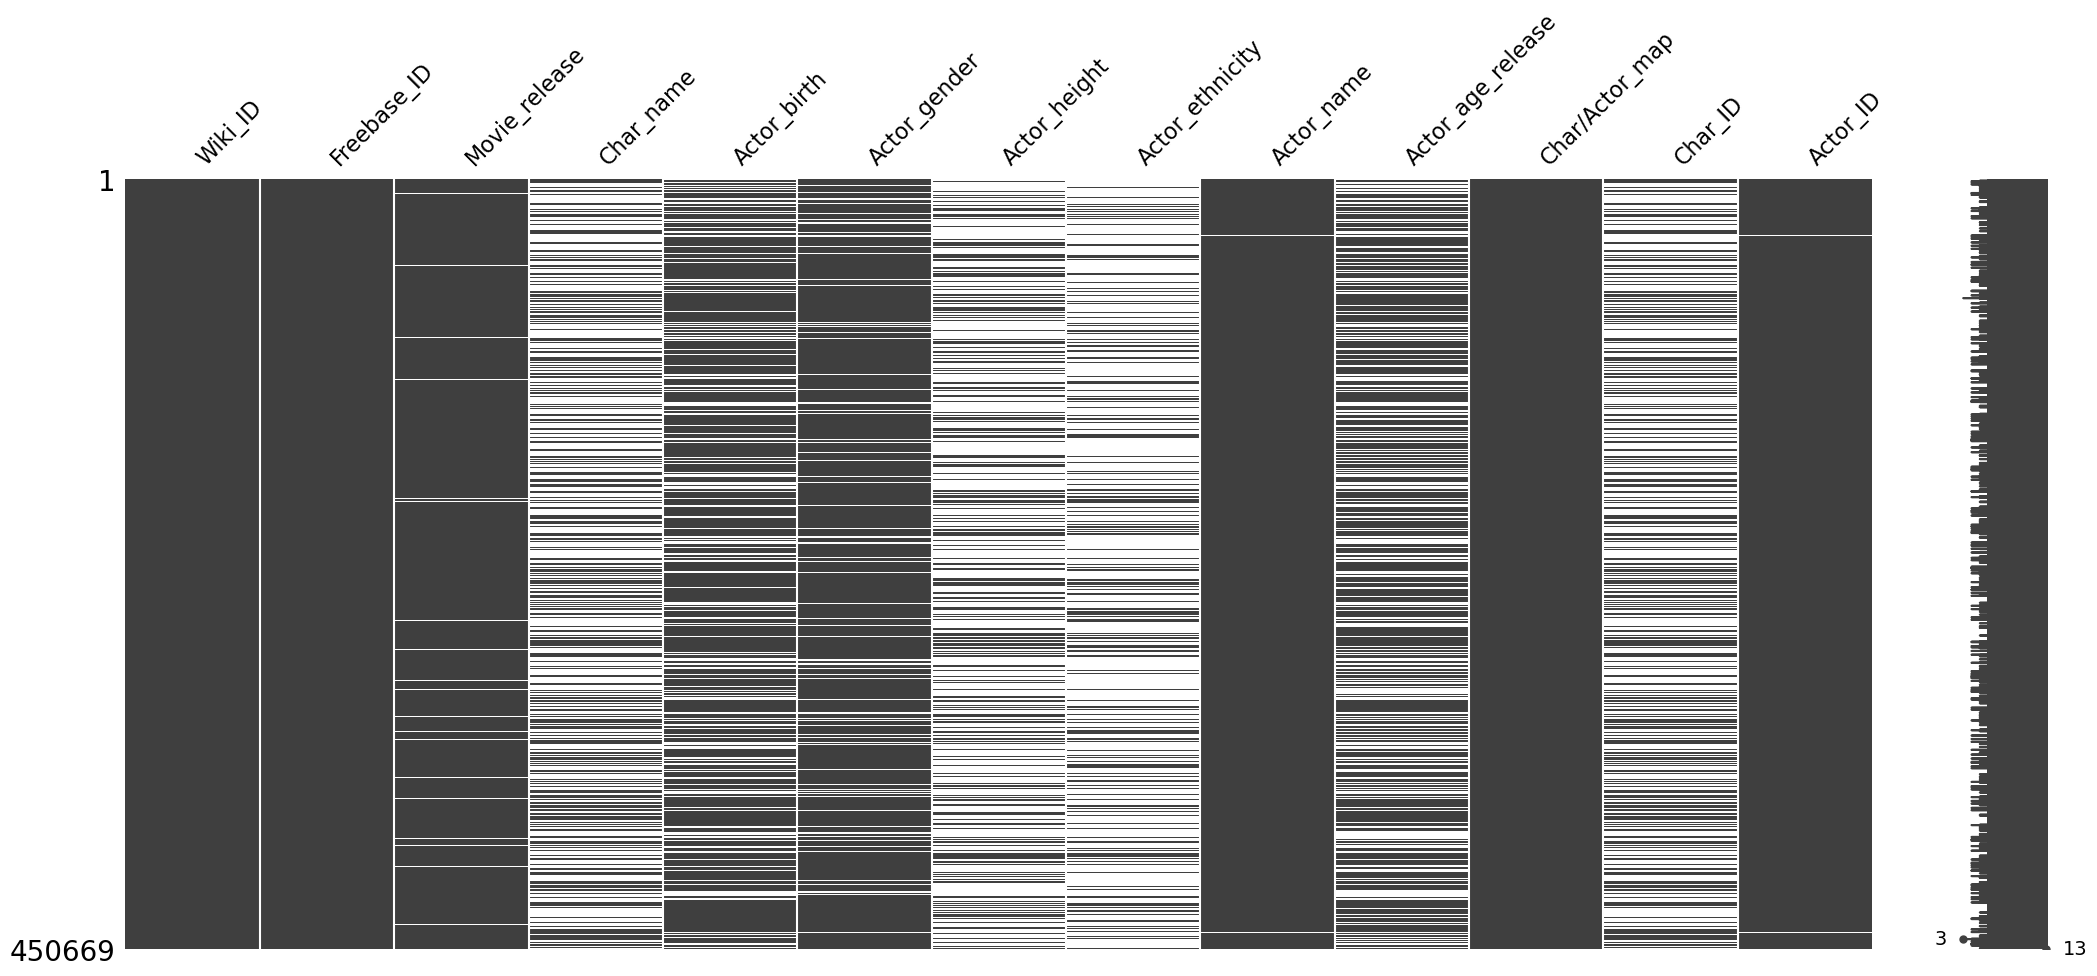

In [8]:
msno.matrix(df_char)

<Axes: >

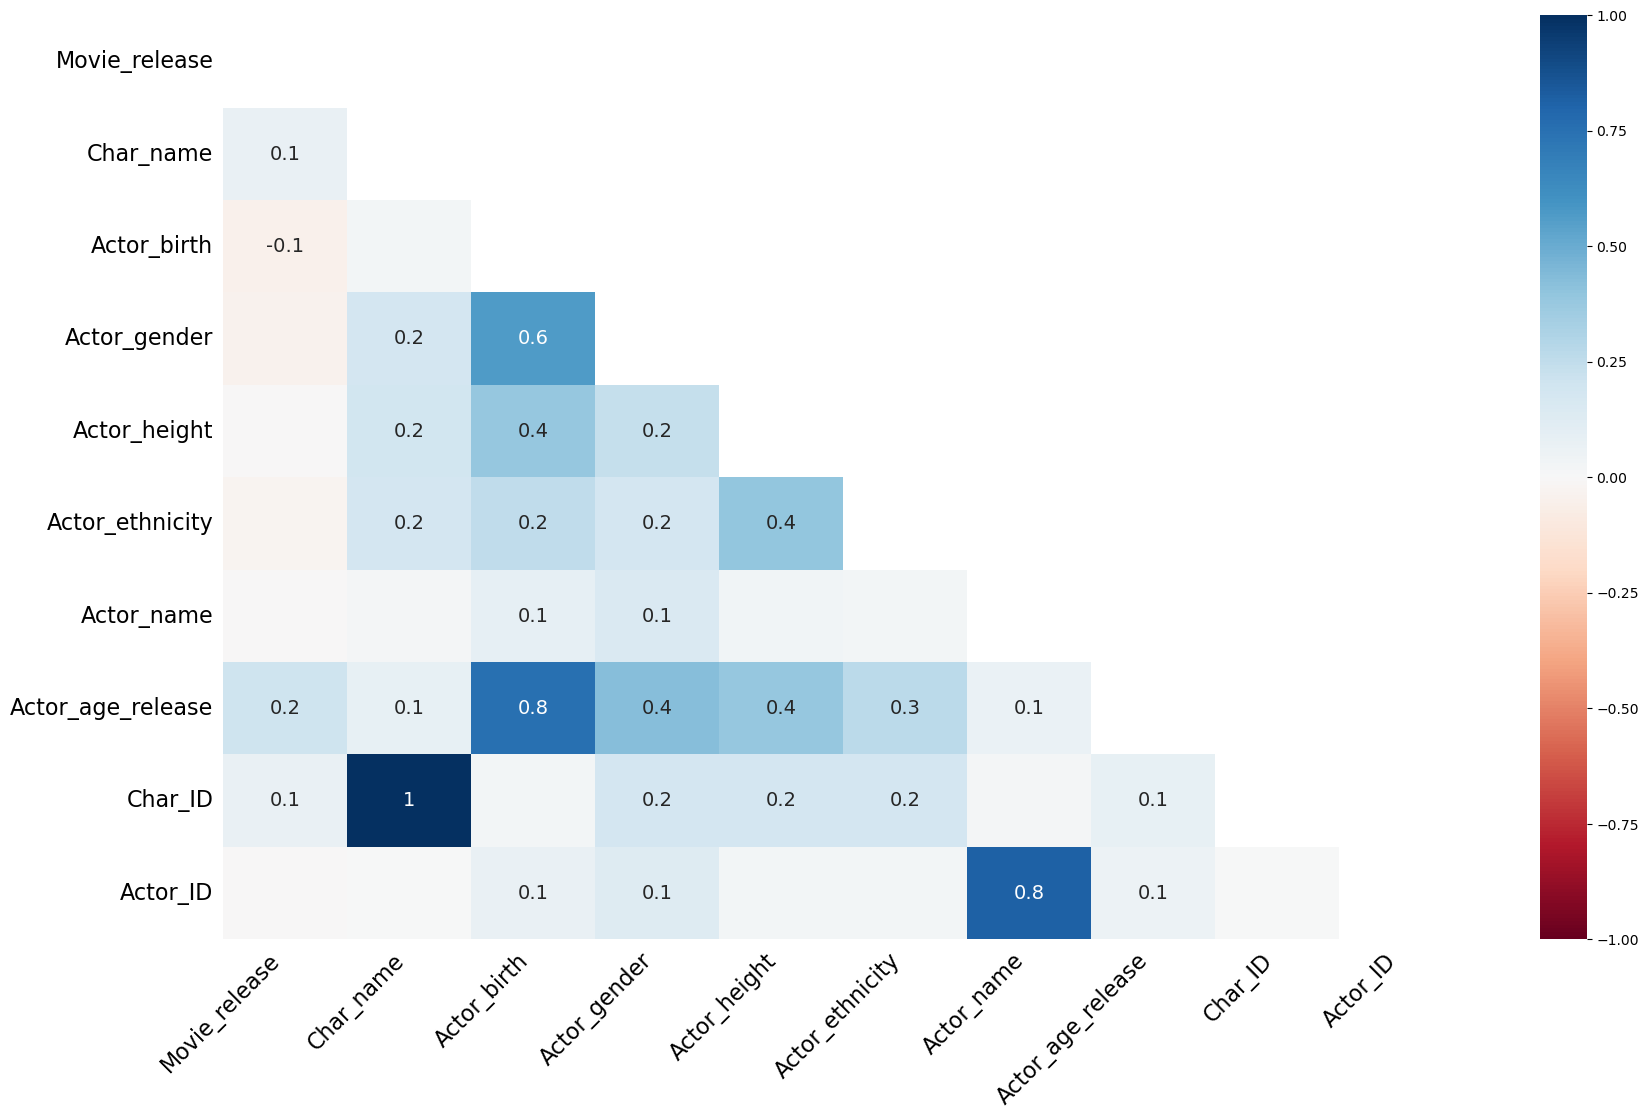

In [9]:
msno.heatmap(df_char)

<Axes: >

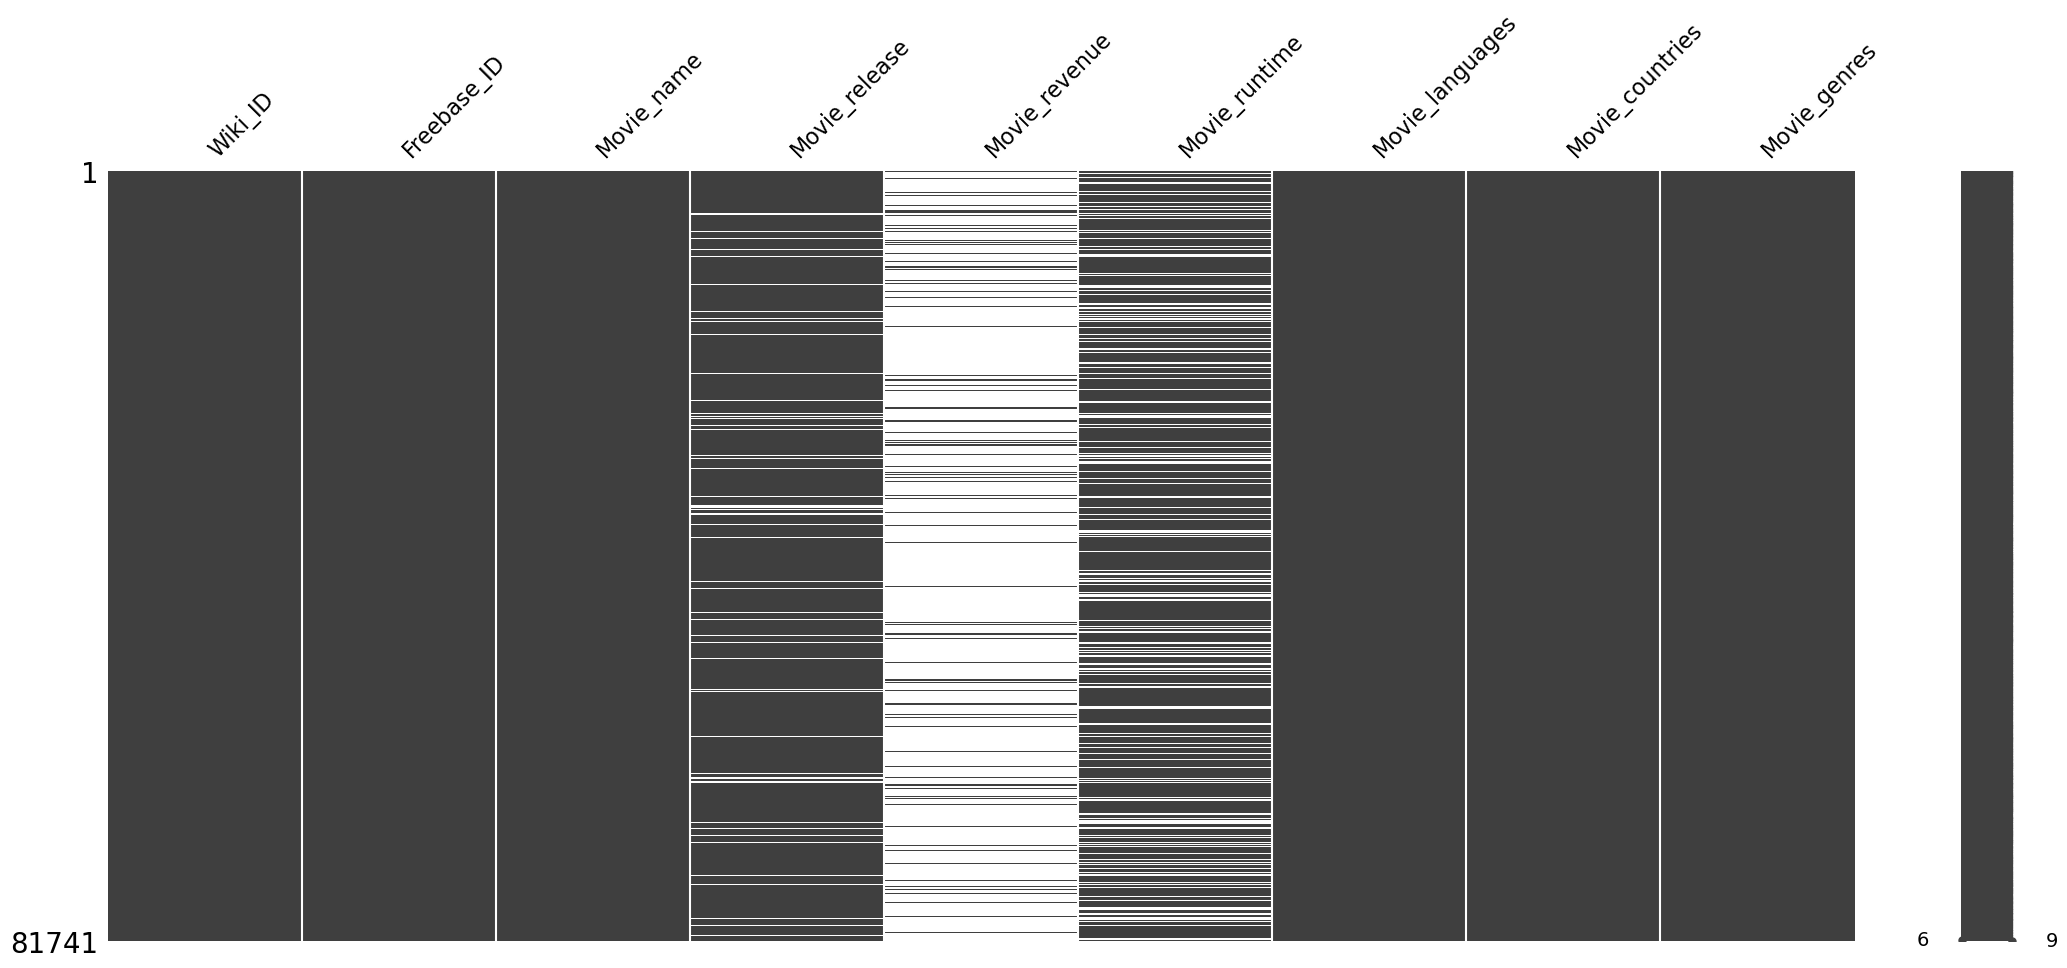

In [10]:
msno.matrix(df_mov)

<Axes: >

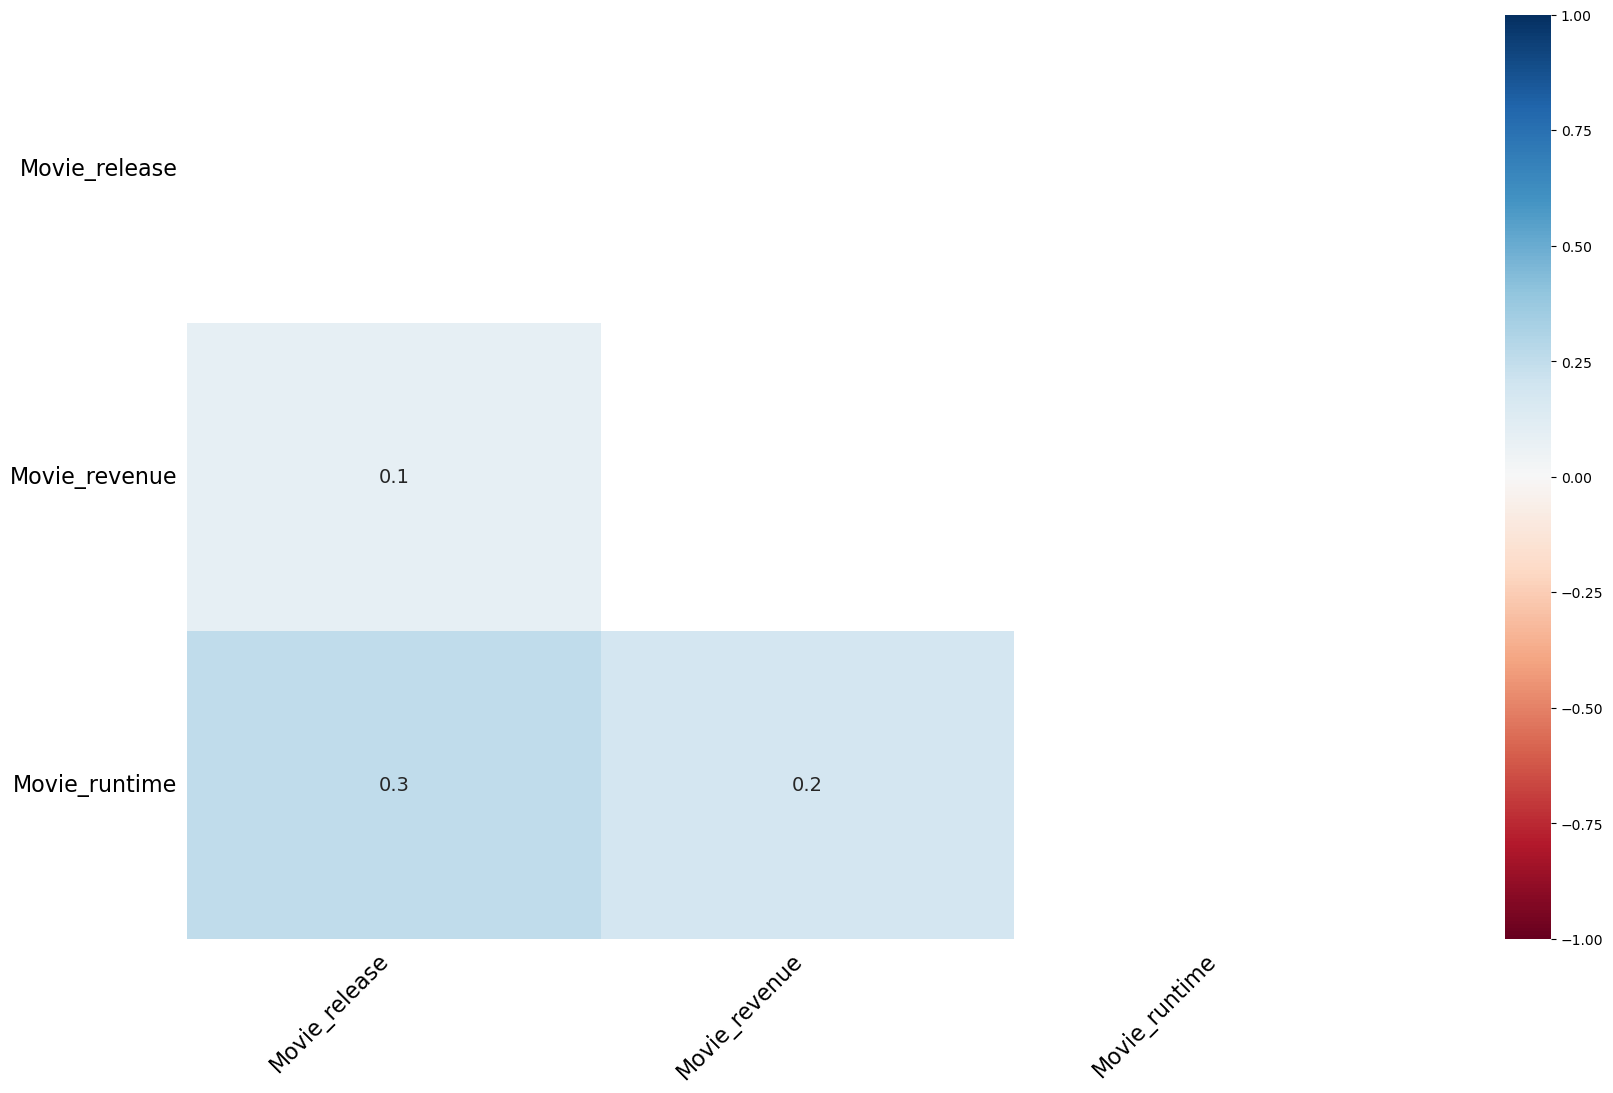

In [11]:
msno.heatmap(df_mov)

### When describing the relevant aspects of the data, and any other datasets you may intend to use, you should in particular show (non-exhaustive list):

**-That you can handle the data in its size.**

**-That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).**

**-That you considered ways to enrich, filter, transform the data according to your needs.**

**-That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.**

**-That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.**

In [50]:
df_mov_rel = df_mov.copy()
df_mov_rel['Movie_release'] = df_mov_rel['Movie_release'].apply(lambda x: float(str(x).split('-')[0]))

In [33]:
df_imdb = pd.read_table('data/imdb_dataV2.tsv')
df_imdb.head(1)

,imdb_rating,type,popular_title,original_title,movie_start_year,movie_end_year,runtime_min,genres,Producer,Composer,director,dir_birth,dir_death,dir_known_titles,writer,writer_birth,writer_death,writer_know_titles
0,5.7,short,Carmencita,Carmencita,1894.0,NaN,1.0,"Documentary,Short",NaN,NaN,William K.L. Dickson,1860.0,1935.0,"tt1428455,tt0219560,tt0308254,tt1496763",NaN,NaN,NaN,NaN


In [34]:
df_movie = df_mov_rel.merge(df_imdb, left_on=['Movie_release', 'Movie_name'], 
                            right_on=['movie_start_year', 'popular_title'], how='left')
df_movie.head(1)

,Wiki_ID,Freebase_ID,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,imdb_rating,...,Producer,Composer,director,dir_birth,dir_death,dir_known_titles,writer,writer_birth,writer_death,writer_know_titles
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,...,Sandy King,Anthrax,John Carpenter,1948.0,NaN,"tt0080749,tt0077651,tt0069945,tt0082340",NaN,NaN,NaN,NaN


In [35]:
print(f"Samples in df_movie: {len(df_movie)}")
print(f"Columns of df_movie: {df_movie.columns}")

Samples in df_movie: 81741
Columns of df_movie: Index(['Wiki_ID', 'Freebase_ID', 'Movie_name', 'Movie_release',
       'Movie_revenue', 'Movie_runtime', 'Movie_languages', 'Movie_countries',
       'Movie_genres', 'imdb_rating', 'type', 'popular_title',
       'original_title', 'movie_start_year', 'movie_end_year', 'runtime_min',
       'genres', 'Producer', 'Composer', 'director', 'dir_birth', 'dir_death',
       'dir_known_titles', 'writer', 'writer_birth', 'writer_death',
       'writer_know_titles'],
      dtype='object')


In [36]:
df_movie = df_movie.drop(['type', 'popular_title', 'original_title', 'runtime_min'
                          , 'genres' , 'dir_birth', 'dir_death', 'dir_known_titles', 'writer_birth', 
                         'writer_death', 'writer_know_titles', 'movie_end_year'], axis=1)
df_movie.head(1)

,Wiki_ID,Freebase_ID,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,imdb_rating,movie_start_year,Producer,Composer,director,writer
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,2001.0,Sandy King,Anthrax,John Carpenter,NaN


In [37]:
df_movie = df_movie.drop(['movie_start_year', 'Freebase_ID'], axis=1).rename(
    columns={'imdb_rating': 'Movie_rating', 'Producer': 'Movie_producer', 
             'Composer': 'Movie_composer', 'director': 'Movie_director',
            'writer': 'Movie_writer'})

# Below is the well processed and augmented movie database

In [38]:
df_movie.head(1)

,Wiki_ID,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_rating,Movie_producer,Movie_composer,Movie_director,Movie_writer
0,975900,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN


# Merge with actor database

In [44]:
df_all = df_movie.merge(df_char, on='Wiki_ID', how='right')
print(f"The database has {len(df_all)} entries")

The database has 450669 entries


In [46]:
df_all = df_all.drop(['Wiki_ID', 'Movie_release_y', 'Freebase_ID', 'Char/Actor_map', 'Char_ID', 
                      'Actor_ID'], axis=1).rename(columns={'Movie_release_x': 'Movie_release'})
df_all.head()

,Movie_name,Movie_release,Movie_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_rating,Movie_producer,Movie_composer,Movie_director,Movie_writer,Char_name,Actor_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_release
0,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0
1,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0
2,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0
3,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0
4,Ghosts of Mars,2001.0,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",4.9,Sandy King,Anthrax,John Carpenter,NaN,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0


<Axes: >

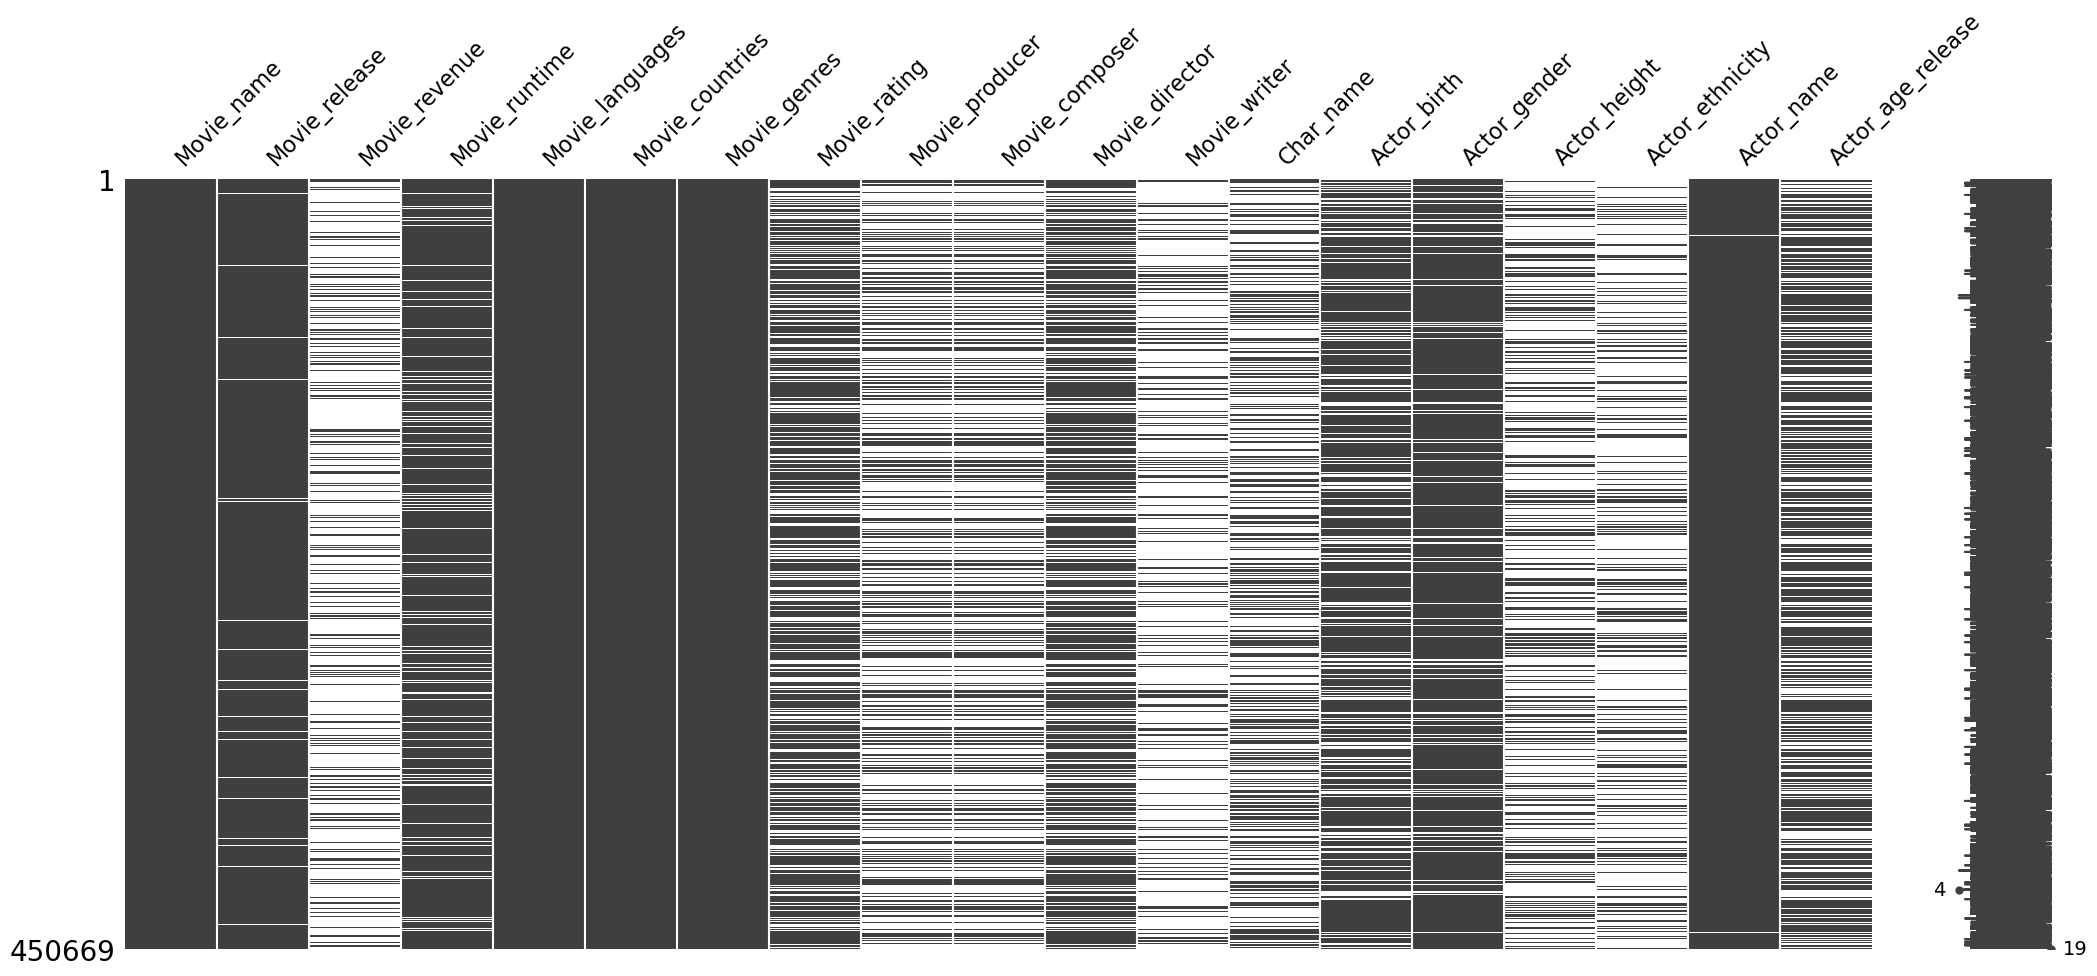

In [47]:
msno.matrix(df_all)

In [48]:
df = df_all.dropna(subset=['Movie_revenue'])
print(f"The database has now {len(df)} entries")

The database has now 101028 entries


<Axes: >

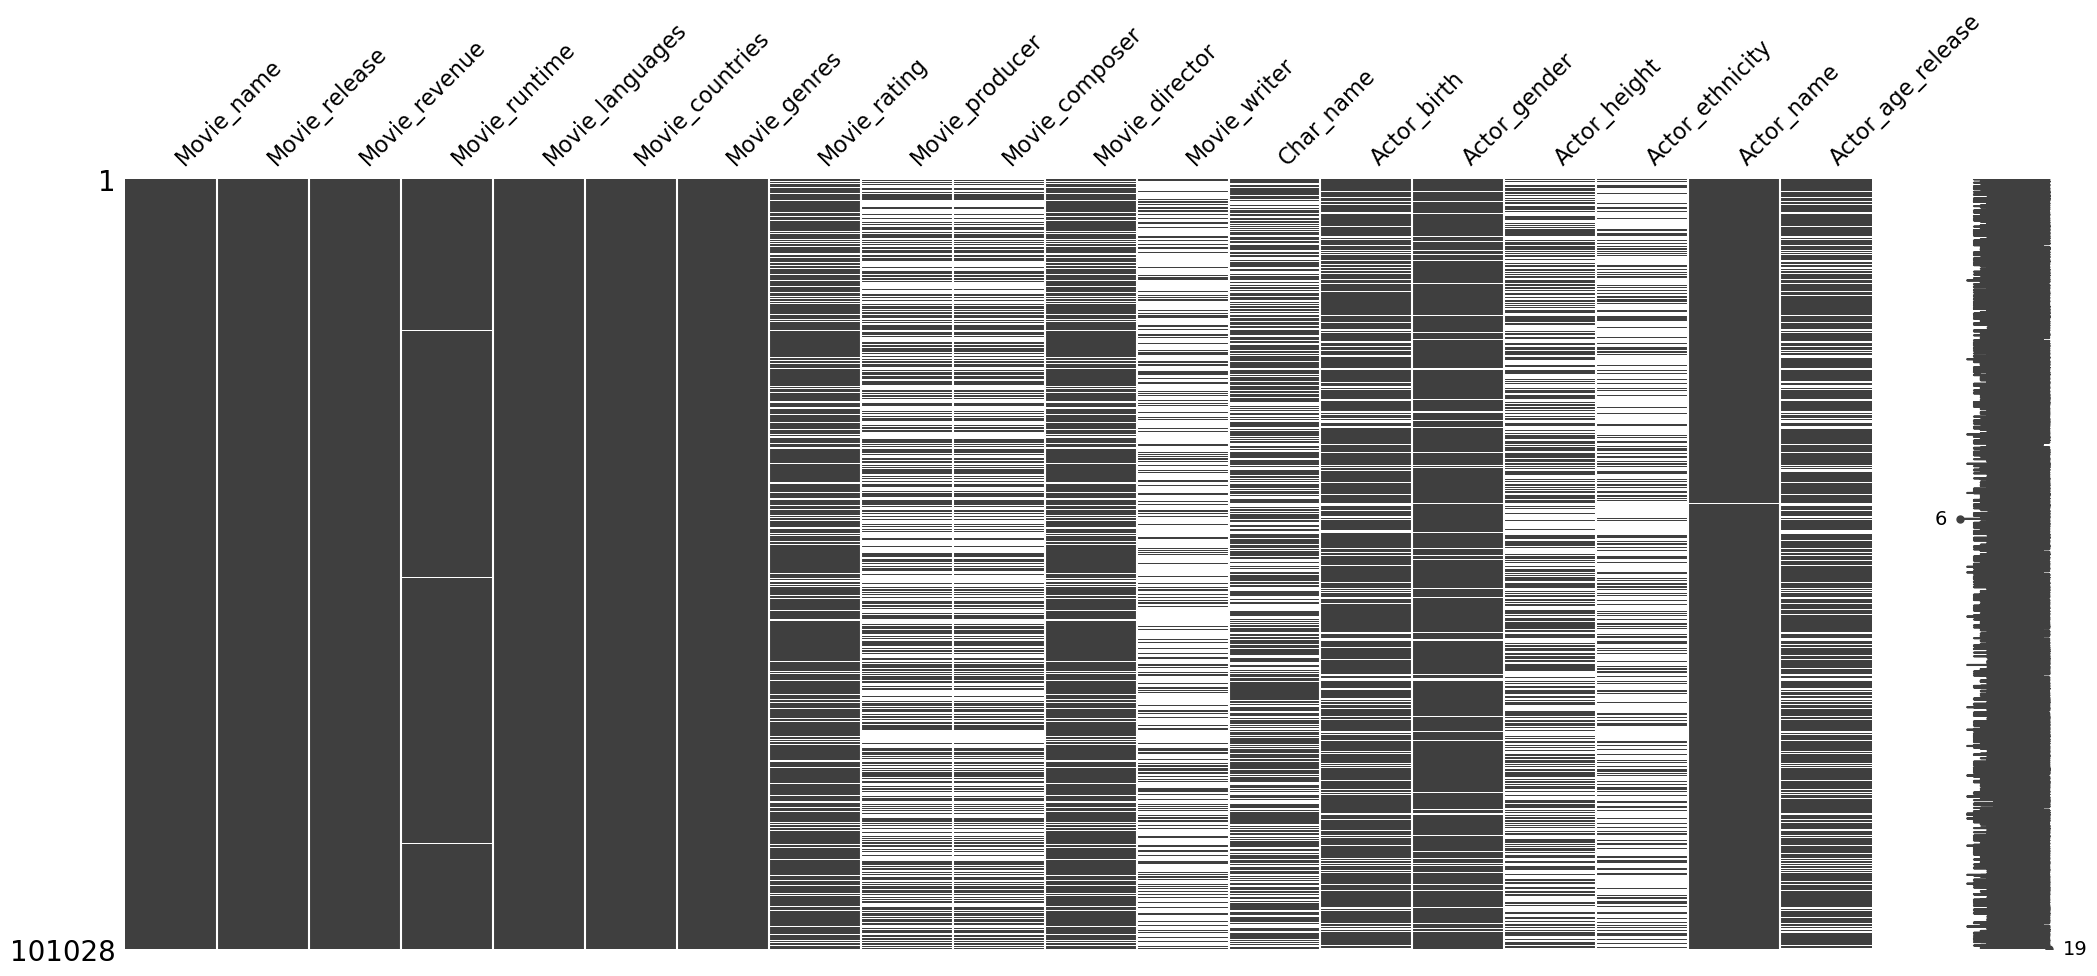

In [49]:
msno.matrix(df)